In [1]:
from random import randint
from collections import defaultdict
from uuid import uuid4
from dataclasses import dataclass
import json

import matplotlib.pyplot as plt
from ipynb.fs.full.Observer import RemoteCamera, CaptureMachine, TrackedObject, CaptureConfiguration, \
    Camera, hStackImages, vStackImages, cameras
import dma.MechaCombat as mc
QuantumSystem = mc.QuantumSystem

In [2]:
@dataclass
class QuantumObject(TrackedObject):
    name: str
    objectType: str

    def __eq__(self, other):
        return super().__eq__(other)
    
    def __post_init__(self):
        super().__post_init__()
        self.qid = str(uuid4())

    def previousVersion(self):
        return type(self)({camNum: change.lastChange if change is not None else None for camNum, change in self.changeSet.items()}, self.name, self.objectType)

    def __repr__(self):
        changeSet = {camNum: cS for camNum, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"QO - {self.objectType} - {self.name} ({changeSet})"

In [3]:
class HarmonyMachine(CaptureMachine):
    states = ["idle", "unstable", "classify", "illegal"]
    modes = ["passive", "calibrate", "add", "move", "action"]
    MM_FOR_MOVE = 15

    def __init__(self, captureConfiguration: CaptureConfiguration):
        super().__init__(captureConfiguration)
        self.hc = self.cc
        mc.qs.reset()
        self.newObjectBuffer = []
        self.selectedObjects = []
        self.mode = "passive"
    
    def isLegal(self, classifiedChange):
        return True
        
    def storeNewObject(self, objDef):
        self.lastMemory = objDef
        if not objDef.isNewObject:
            existingIndex = self.newObjectBuffer.index(objDef.previousVersion())
            existingObj = self.newObjectBuffer[existingIndex]
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        else:
            self.newObjectBuffer.append(objDef)
        
        for camNum, change in objDef.changeSet.items():
            cameras[camNum].commitChange(change)
        
        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in cameras.items()}})
    
    def commitChanges(self, objDef):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            existingObj = self.memory[existingIndex]
            print(f"Updating Memory {existingIndex}")
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        except Exception:
            raise Exception("Cannot commit to unrecognized memory")
        self.lastMemory = existingObj
        
        for camNum, change in objDef.changeSet.items():
            cameras[camNum].commitChange(change)

        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in cameras.items()}})

    def annotateObject(self, oid, objName, objType):
        caps = {cap.oid: cap for cap in self.newObjectBuffer}
        cap = caps[oid]
        center = self.cc.rsc.changeSetToRealCenter(cap)
        qObj = QuantumObject(cap.changeSet, objName, objType)
        factory = mc.ObjectFactories[objType]
        factory(objName, "Unaligned")
        mc.XYLocation.set_location(objName, json.dumps(list(center) + [0]))
        self.memory.append(qObj)
        self.newObjectBuffer.remove(cap)
    
    def cycle(self):
        try:
            print(f"Starting Cycle {self.cycleCounter:5} -- {self}")
            self.cycleCounter += 1
            nextState = "idle"
            self.hc.capture()
            if self.mode == "passive":
                self.hc.setReference()
                return
            # else: mode in ["calibrate", "add", "move", "attack"]

            changes = self.referenceFrameDeltas()
            classification = None

            if changes.empty and self.state == "idle":
                self.hc.setReference()
            elif not changes.empty:
                nextState = "unstable"
                if self.state in ["unstable", "classify"] and changes == self.lastChanges:  # TODO: and cameraChangeOverlap
                    classification = self.classifyChanges(changes)
                    nextState = "classify"
                    if self.state == "classify":
                        if self.mode == "action":
                            assert not classification.isNewObject, f"Cannot add objects in {self.mode}"
                        elif self.mode in ["move", "action"]:
                            assert not classification.isNewObject, f"Cannot add objects in {self.mode}"
                            if self.mode == "move":
                                assert self.isLegal(classification), f"{classificaton} is an illegal move"
                            elif self.mode == "action":
                                assert self.cc.rsc.trackedObjectLastDistance(classification) < self.MM_FOR_MOVE, f"{classification} moves too far for selection"
                                
                            nextState = "idle"
                            self.commitChanges(classification)
                            if self.mode == "action":
                                self.selectedObjects = list(set(self.selectedObjects.append(self.lastMemory)))
                                if len(self.selectedObjects) == 2:
                                    pass
                                    # Test Legality of Attack between sO[0] -> sO[1]
                                    # if legal, Calculate SATOR for Attack
                            self.hc.setReference()
                        elif self.mode == "add":
                            nextState = "idle"
                            self.storeNewObject(classification)
                            self.hc.setReference()
                        elif self.mode == "calibrate":
                            try:
                                self.calibrateToObject(classification)
                            except AssertionError as ae:
                                print(f"Failed Calibration: {ae}")
                            nextState = "idle"
                            self.hc.setReference()
                        else:
                            raise Exception("Unrecognized State")
            self.state = nextState
            self.lastChanges = changes
            self.lastClassification = classification
        except:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            self.state = "unstable"
            self.lastChanges = None
            self.lastClassification = None
    
    def actionMode(self):
        self.selectedObjects = []
        self.mode = "action"
    
    def moveMode(self):
        self.mode = "move"
    
    def addMode(self):
        self.mode = "add"
    
    def passiveMode(self):
        self.mode = "passive"
    
    def startCalibration(self):
        self.calibrationPts = []
        self.mode = "calibrate"
    
    def abortCalibration(self):
        self.calibrationPts = []
        self.mode = "passive"
            
    def cycleForAddition(self):
        self.mode = "add"
        startLen = len(self.newObjectBuffer)
        while len(self.newObjectBuffer) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.newObjectBuffer[-1]
            
    def cycleForChange(self):
        self.mode = "move"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def cycleForAction(self):
        self.mode = "action"
        startLen = len(self.transitions)
        while len(self.transitions) < startLen + 2:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state}"

In [4]:
print("Building Harmony Machine")
cc = CaptureConfiguration()
cm = HarmonyMachine(cc)

Waiting for object...
Starting Cycle     0 -- CapMac -- add idle
Starting Cycle     1 -- CapMac -- add idle
Starting Cycle     2 -- CapMac -- add unstable
Starting Cycle     3 -- CapMac -- add unstable
Starting Cycle     4 -- CapMac -- add unstable
Starting Cycle     5 -- CapMac -- add classify
Cam 2 - Adding (add) [1215.0, 772.0] by 84.0,90.0
Cam 4 - Adding (add) [1120.0, 558.0] by 92.0,108.0
Cam 6 - Adding (add) [596.0, 577.0] by 85.0,81.0


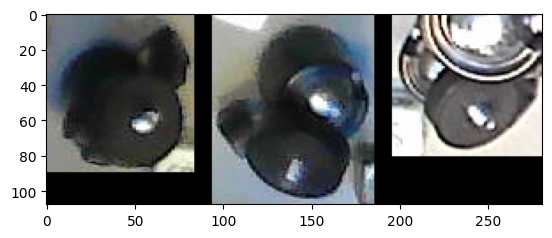

In [5]:
if __name__ == "__main__":
    for i in range(3):
        cm.cc.capture()
    print("Waiting for object...")
    obj = cm.cycleForAddition()
    cm.annotateObject(obj.oid, "Foo", "Huntsman")
    plt.imshow(obj.visual())

Waiting for movement
Starting Cycle     6 -- CapMac -- move idle
Starting Cycle     7 -- CapMac -- move idle
Starting Cycle     8 -- CapMac -- move idle
Starting Cycle     9 -- CapMac -- move unstable
Starting Cycle    10 -- CapMac -- move unstable
Starting Cycle    11 -- CapMac -- move unstable
Starting Cycle    12 -- CapMac -- move classify
Updating Memory 0
In update: overwrite - True
Cam 2 - Moving (add) [1215.0, 772.0] by 84.0,90.0 to (move) [1362.0, 732.0] by 69.0,86.0
Cam 4 - Moving (add) [1120.0, 558.0] by 92.0,108.0 to (move) [962.0, 581.0] by 89.0,107.0
Cam 6 - Moving (add) [596.0, 577.0] by 85.0,81.0 to (move) [670.0, 686.0] by 83.0,99.0


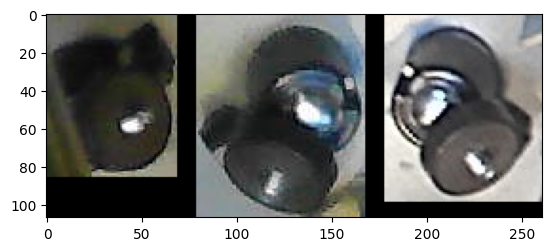

Waiting for movement
Starting Cycle    13 -- CapMac -- move idle
Starting Cycle    14 -- CapMac -- move idle
Starting Cycle    15 -- CapMac -- move idle
Starting Cycle    16 -- CapMac -- move unstable
Starting Cycle    17 -- CapMac -- move unstable
Starting Cycle    18 -- CapMac -- move classify
Updating Memory 0
In update: overwrite - True
Cam 2 - Moving (move) [1362.0, 732.0] by 69.0,86.0 to (move) [1341.0, 730.0] by 27.0,63.0
Cam 4 - Moving (move) [962.0, 581.0] by 89.0,107.0 to (move) [1011.0, 577.0] by 93.0,106.0
Cam 6 - Moving (move) [670.0, 686.0] by 83.0,99.0 to (move) [652.0, 648.0] by 82.0,103.0


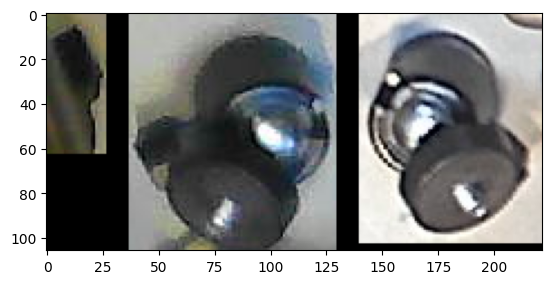

In [6]:
if __name__ == "__main__":
    for i in range(2):
        print("Waiting for movement")
        obj = cm.cycleForChange()
        plt.imshow(obj.visual())
        plt.show()